In [2]:
!wget --no-check-certificate https://storage.googleapis.com/platzi-tf2/sign-language-img.zip \
    -O /tmp/sign-language-img.zip

--2023-04-02 21:31:31--  https://storage.googleapis.com/platzi-tf2/sign-language-img.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.119.128, 142.250.153.128, 142.250.145.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.119.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24265584 (23M) [application/zip]
Saving to: ‘/tmp/sign-language-img.zip’

/tmp/sign-language- 100%[===================>]  23.14M  21.5MB/s    in 1.1s    

2023-04-02 21:31:32 (21.5 MB/s) - ‘/tmp/sign-language-img.zip’ saved [24265584/24265584]



#Descomprimir la base de datos y almacenarla en carpetas training y test

In [3]:
import os
import zipfile

local_zip = "/tmp/sign-language-img.zip"
zip_ref = zipfile.ZipFile(local_zip, "r")
zip_ref.extractall("/tmp/sign-language-img")
zip_ref.close()

In [4]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import string
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [5]:
train_dir = "/tmp/sign-language-img/Train"
test_dir = "/tmp/sign-language-img/Test"

#Data Generators

In [6]:
train_datagen = ImageDataGenerator(rescale = 1/255)
test_datagen = ImageDataGenerator(rescale = 1/255, validation_split= 0.2)

In [7]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (28, 28),
    batch_size = 128,
    class_mode = "categorical",
    color_mode = "grayscale",
    subset = "training"
)

validation_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = (28, 28),
    batch_size = 128,
    class_mode = "categorical",
    color_mode = "grayscale",
    subset = "validation"
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = (28, 28),
    batch_size = 128,
    class_mode = "categorical",
    color_mode = "grayscale"
)

Found 27455 images belonging to 24 classes.
Found 1425 images belonging to 24 classes.
Found 7172 images belonging to 24 classes.


In [8]:
classes = [char for char in string.ascii_uppercase if char != "J" if char != "Z"]

#Visualización de la data

In [9]:
def plotImages(images_arr):
  fig, axes = plt.subplots(1, 5, figsize = (10, 10))
  axes = axes.flatten()
  for img, ax in zip(images_arr, axes):
    ax.imshow(img[:,:,0])
    ax.axis("off")
  plt.tight_layout()
  plt.show()

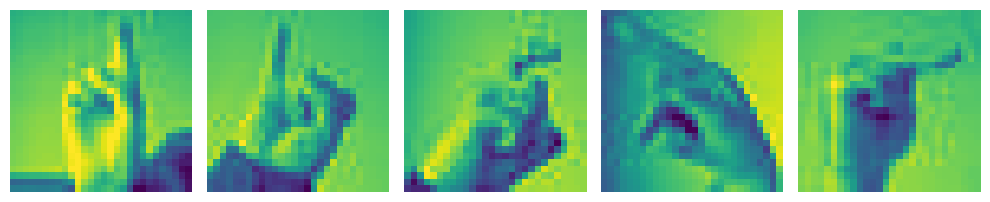

In [10]:
sample_training_images, _= next(train_generator)
plotImages(sample_training_images[:5])

In [11]:
train_generator_resize = train_datagen.flow_from_directory(
    train_dir,
    target_size = (150, 150),
    batch_size = 128,
    class_mode = "categorical",
    color_mode = "rgb",
    subset = "training"
)

validation_generator_resize = test_datagen.flow_from_directory(
    test_dir,
    target_size = (150, 150),
    batch_size = 128,
    class_mode = "categorical",
    color_mode = "rgb",
    subset = "validation"
)

test_generator_resize = test_datagen.flow_from_directory(
    test_dir,
    target_size = (150, 150),
    batch_size = 128,
    class_mode = "categorical",
    color_mode = "rgb"
)

Found 27455 images belonging to 24 classes.
Found 1425 images belonging to 24 classes.
Found 7172 images belonging to 24 classes.


#Modelo pre-entrenado con modelo de Keras

In [12]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

pre_trained_model = InceptionV3(
    include_top = False,
    input_tensor = tf.keras.layers.Input(shape = (150, 150, 3))
)

for layer in pre_trained_model.layers:
  layer.trainable = False

pre_trained_model.summary()

87910968/87910968 [==============================] - 4s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                      

In [13]:
last_layers= pre_trained_model.get_layer("mixed7")
last_output = last_layers.output

In [14]:
x = tf.keras.layers.Flatten()(last_output)
x = tf.keras.layers.Dense(128, activation = "relu")(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(len(classes), activation= "softmax")(x)

model_keras = tf.keras.Model(pre_trained_model.input, x)

model_keras.compile(optimizer= "adam", loss = "categorical_crossentropy", metrics = ["accuracy"])
model_keras.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

In [15]:
history_keras = model_keras.fit(
    train_generator_resize,
    epochs = 5,
    validation_data = validation_generator_resize
)

Epoch 1/5
215/215 [==============================] - 49s 164ms/step - loss: 0.1404 - accuracy: 0.9618 - val_loss: 0.0844 - val_accuracy: 0.9719
Epoch 2/5
215/215 [==============================] - 32s 147ms/step - loss: 0.0039 - accuracy: 0.9992 - val_loss: 0.0465 - val_accuracy: 0.9832
Epoch 3/5
215/215 [==============================] - 32s 149ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.0402 - val_accuracy: 0.9867
Epoch 4/5
215/215 [==============================] - 32s 151ms/step - loss: 9.4134e-04 - accuracy: 0.9999 - val_loss: 0.0452 - val_accuracy: 0.9818
Epoch 5/5
215/215 [==============================] - 32s 147ms/step - loss: 6.5188e-04 - accuracy: 1.0000 - val_loss: 0.0425 - val_accuracy: 0.9853


In [16]:
results = model_keras.evaluate(test_generator_resize)

57/57 [==============================] - 9s 144ms/step - loss: 0.0514 - accuracy: 0.9851


#Visualización y análisis de los resultados

In [20]:
def visualizacion_resultados(history):
  epochs = [i for i in range(5)]
  fig, ax = plt.subplots(1,2)
  train_acc = history.history["accuracy"]
  train_loss = history.history["loss"]
  val_acc = history.history["val_accuracy"]
  val_loss = history.history["val_loss"]
  fig.set_size_inches(16, 9)

  ax[0].plot(epochs, train_acc, "go-", label =" Entrenamiento accuracy")
  ax[0].plot(epochs, val_acc, "ro-", label= "Validacion accuracy")
  ax[0].set_title("Entrenamiento & validación accuracy")
  ax[0].legend()
  ax[0].set_xlabel("Epochs")
  ax[0].set_ylabel("Accuracy")

  ax[1].plot(epochs, train_loss, "go-", label =" Entrenamiento Loss")
  ax[1].plot(epochs, val_loss, "ro-", label= "Validacion Loss")
  ax[1].set_title("Entrenamiento & validación Loss")
  ax[1].legend()
  ax[1].set_xlabel("Epochs")
  ax[1].set_ylabel("Loss")

  plt.show()


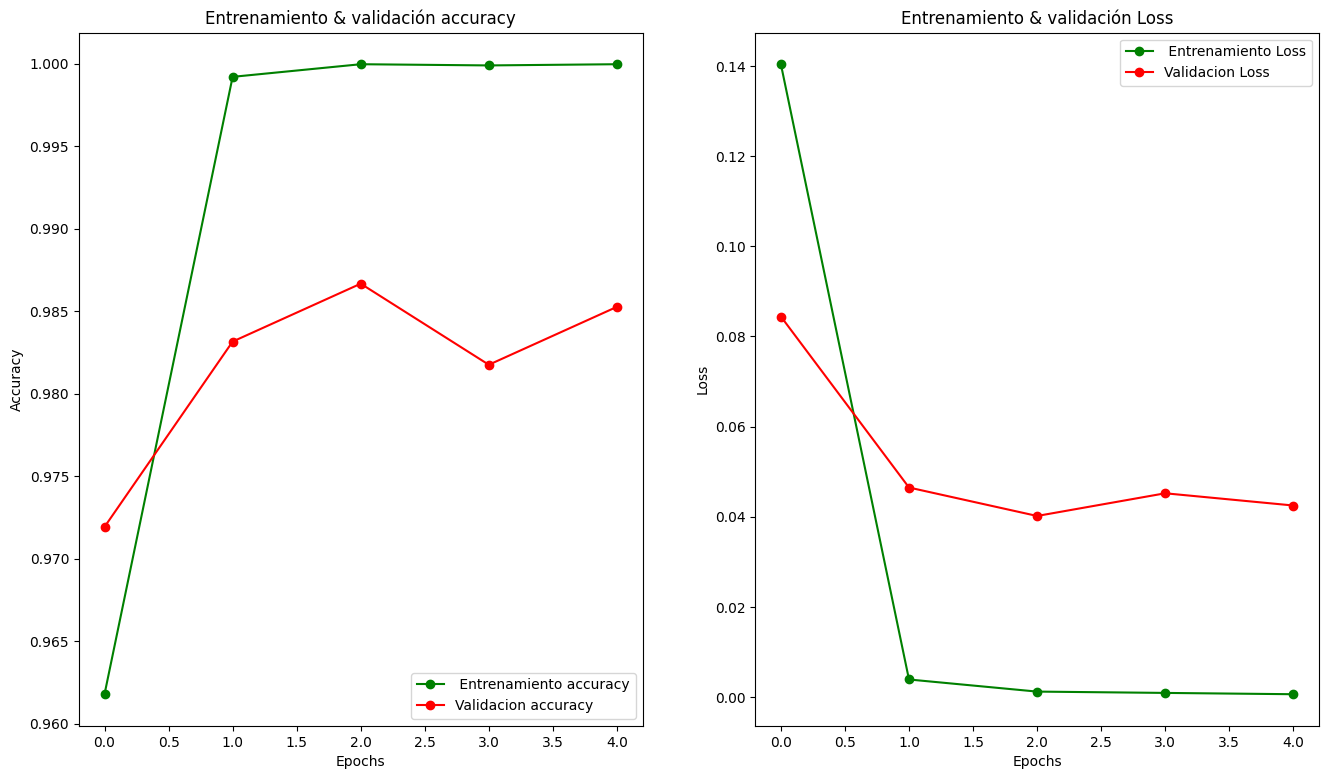

In [21]:
visualizacion_resultados(history_keras)

#Usar el formato .h5 para guardar modelos

In [22]:
!pip install pyyaml h5py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [23]:
model_keras.save("my_model_sign_languages.h5")